In [49]:
from torch_geometric.datasets import KarateClub
from torch_geometric.utils.convert import to_networkx
from graph_torch.dynamicGraph import dynamicGraph
from graph_torch.sampler.n2v_random_walk import UnweightedNode2vecSampler
from graph_torch.nn.node2vecLayer import node2vec_layer
from graph_torch.nn.gcn import GCN_layer
import torch
import networkx as nx
from torch.optim import SparseAdam
from umap import UMAP
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Karate Club Graph dataset

In [50]:
dataset = KarateClub()[0]

## Visualize the Karate Club Graph and its node labels

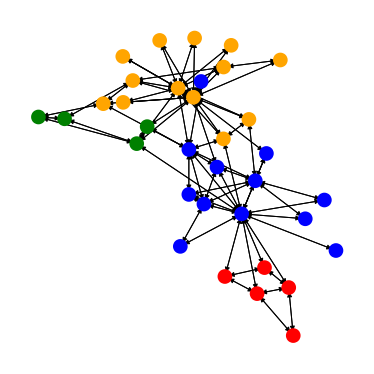

In [51]:
karategraph = to_networkx(dataset)

colors = ['blue', 'red', 'orange', 'green']
node_labels = dataset.y[list(karategraph.nodes)].numpy()
node_colors = [colors[elm] for elm in node_labels]

plt.figure(1,figsize=(5,5)) 
nx.draw(karategraph, node_color = node_colors, node_size=75, linewidths=6)
plt.show()

## initialize the dynamic graph

In [52]:
from torch import rand

dataset = KarateClub()[0]
embedding_dim = 64
node_num = dataset.num_nodes

# Initialize graph 
dg = dynamicGraph()

# Add randomly initialized node embeddings to the graph
dg.add_nodes({ "w": rand(node_num, embedding_dim) / 10, # TO DO: initialize node embeddings by calling the Node class
             })

# Add edges to the graph
dg.add_edges(edge_type = "e", 
             U = dataset.edge_index[0], 
             V = dataset.edge_index[1], 
             directed = False
            )


## Plot the random embeddings via UMAP

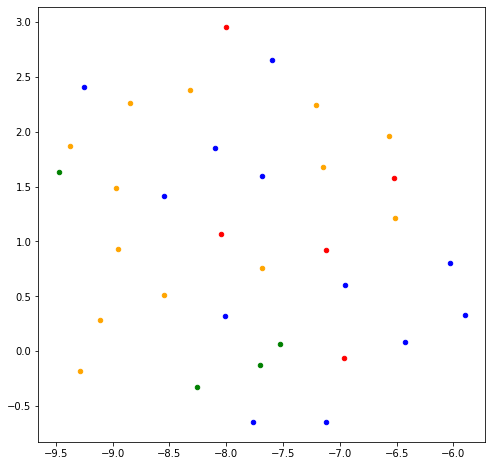

In [53]:
z = dg.get_node_data('w').detach()
z = UMAP(n_components=2).fit_transform(z.cpu().numpy())
y = dataset.y.cpu().numpy()
target = torch.eye(5)[y]

colors = ['blue', 'red', 'orange', 'green']
plt.figure(figsize=(8, 8))
for i in range(dataset.y.max().item() + 1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])

## Initialize the random walk strategy for Node2Vec

In [54]:
n2v_sampler = UnweightedNode2vecSampler(graph = dg, 
                                        edge_type = 'e', 
                                        walk_length = 15, 
                                        context_size = 5, 
                                        walks_per_node = 10,
                                        num_negative_samples = 1, 
                                        p = 0.5, 
                                        q = 1, 
                                        sparse = True
                                       )

generator = n2v_sampler.generator(batch_size = 10, 
                                  shuffle = True, 
                                  num_workers = 0,
                                  batch = None
                                 )

## train Node2Vec

In [55]:
epochs = 1000
lr = 0.01
n2v_layer = node2vec_layer(graph = dg, 
                           node_type = 'w'
                          )
optimizer = SparseAdam(list(n2v_layer.parameters()), lr = lr)

n2v_layer.train()
for i in range(epochs):
    for pos, neg in generator:
        optimizer.zero_grad()
        loss = n2v_layer.loss(pos, neg)
        loss.backward()
        optimizer.step()

## Plot the learned embeddings via UMAP

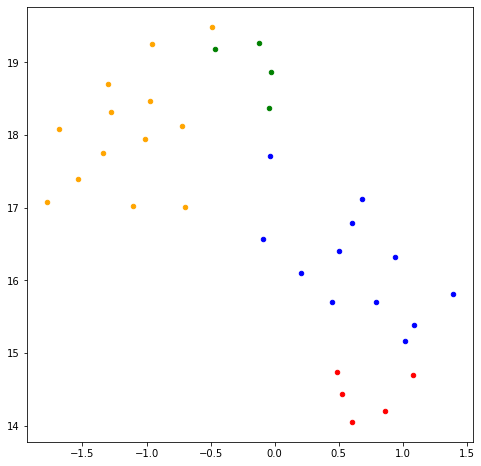

In [56]:
n2v_layer.eval()
z = n2v_layer(torch.arange(dg.get_nodes_num())).detach()
z = UMAP(n_components=2).fit_transform(z.cpu().numpy())
y = dataset.y.cpu().numpy()

colors = ['blue', 'red', 'orange', 'green']
plt.figure(figsize=(8, 8))
for i in range(dataset.y.max().item() + 1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])

## Build "deep" GCN 

In [82]:
import numpy as np

X = dg.node_data['w']
edges = dg.edge_data['e']


class deep_gcn(torch.nn.Module):
    
    def __init__(self, n_input_features: int, n_output_features: int):
        super(deep_gcn, self).__init__()
        
        self.hidden_layer1 = GCN_layer(in_channels=n_input_features,
                                      out_channels= 32,
                                      add_self_loops = True
                                     )
        self.hidden_layer2 = GCN_layer(in_channels= 32,
                                      out_channels= 16,
                                      add_self_loops = True
                                     )
                
        self.output_layer = GCN_layer(in_channels = 16,
                          out_channels = 5,
                          add_self_loops = True
                         )
    
    def forward(self, x, edges):
        # Apply hidden layers module
        out1 = relu(self.hidden_layer1(x, edges))
        out2 = relu(self.hidden_layer2(out1, edges))
        
        # Apply last layer (=output layer) without selu activation
        output = torch.softmax(self.output_layer(out2, edges), dim = 1)
        return output

## Initiate model & Train GCN

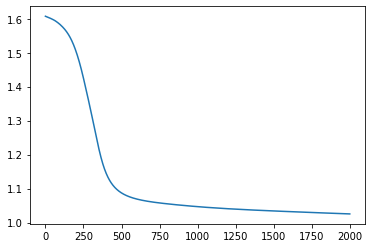

In [96]:
gcn_model = deep_gcn(n_input_features = 64, 
                     n_output_features = 5
                    )

optimizer = torch.optim.SGD(gcn_model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss(reduction="mean")

loss_list = []
for update in range(2000):
    output = gcn_model(X, dg.edge_data['e'])
    loss = loss_function(output, torch.tensor(y).type(torch.LongTensor))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.data.item())

plt.plot(range(len(loss_list)), loss_list)